In [37]:
import pandas
import numpy as np
import tensorflow as tf
import os
import math
import random as rand
from random import random

# Data Preparation

In [2]:
trainDataFile = 'ijcnlp_dailydialog/train/dialogues_train.txt'
trainLabelsFile = 'ijcnlp_dailydialog/train/dialogues_act_train.txt' 

In [3]:
valDataFile = 'ijcnlp_dailydialog/validation/dialogues_validation.txt'
valLablesFile = 'ijcnlp_dailydialog/validation/dialogues_act_validation.txt'

In [4]:
testDataFile = 'ijcnlp_dailydialog/test/dialogues_test.txt'
testLablesFile = 'ijcnlp_dailydialog/test/dialogues_act_test.txt'

In [5]:
lineSeparator = '__eou__'

In [6]:
def getData(dialogueFile, labelFile):
    with open(dialogueFile) as f:
        lines = f.readlines() 
    with open(labelFile) as f:
        labels = f.readlines()    
    
    inputs = []
    inputs_all = []
    for line in lines:
        line = line.rstrip()
        line = line.split(lineSeparator)
        inputs.append(line[:-1])
        inputs_all.extend(line[:-1])
    
    acts = []
    acts_all = []
    for label in labels:
        label = label.rstrip()
        label = label.split()
        
        label = np.array(list(map(int, label))) - 1
        acts.append(label)
        acts_all.extend(label)
        
    return (inputs_all, inputs, acts_all, acts)

In [7]:
trainX_all, trainX_data, trainY_all, trainY = getData(trainDataFile, trainLabelsFile)
valX_all, valX_data, valY_all, valY = getData(valDataFile, valLablesFile)
testX_all, testX_data, testY_all, testY = getData(testDataFile, testLablesFile)

In [8]:
train_dialogues = len(trainX_all)
val_dialogues = len(valX_all)
test_dialogues = len(testX_all)
fullData_temp = trainX_all + valX_all + testX_all

In [9]:
embed_size = 300;
pad_token = '<pad>'
unknown_token = '<unk>'
# embed_path = '/home/abhishekjindal/nlp/data/glove.840B.300d.txt'
embed_path = '../../GenderBiasAnalysis/InferSent/dataset/GloVe/glove.840B.300d.txt'

In [10]:
%matplotlib inline

from random import randint
import matplotlib

import numpy as np
import torch

torch.nn.Module.dump_patches = True

In [11]:
%%time
# sentEmbedModel = torch.load('encoder/infersent.allnli.pickle', map_location=lambda storage, loc: storage)

sentEmbedModel = torch.load('encoder/infersent.allnli.pickle')
sentEmbedModel = sentEmbedModel.cuda()

/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'models.BLSTMEncoder' has changed. Saved a reverse patch to BLSTMEncoder.patch. Run `patch -p0 < BLSTMEncoder.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)
/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. Saved a reverse patch to LSTM.patch. Run `patch -p0 < LSTM.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)


CPU times: user 2.24 s, sys: 808 ms, total: 3.05 s
Wall time: 3.05 s


In [12]:
sentEmbedModel.is_cuda()

True

In [13]:
sentEmbedModel.set_glove_path(embed_path)

In [14]:
%%time
# sentEmbedModel.build_vocab(fullData_temp, tokenize=True)
sentEmbedModel.build_vocab_k_words(K=10000)

Vocab size : 10000
CPU times: user 1.65 s, sys: 284 ms, total: 1.94 s
Wall time: 1.93 s


In [15]:
%%time
final_emb = sentEmbedModel.encode(fullData_temp, bsize=128, tokenize=False, verbose=False)
#final_emb = sentEmbedModel.encode(fullData_temp, tokenize=True)

/home/aananya/Work/Test/PGM/models.py:209: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  sentences[stidx:stidx + bsize]), volatile=True)


CPU times: user 9.4 s, sys: 12.6 s, total: 22 s
Wall time: 22 s


In [16]:
final_emb.shape

(102979, 4096)

In [17]:
curr_count = 0
train_emb_data = final_emb[curr_count:(curr_count+train_dialogues)]
curr_count += train_dialogues
val_emb_data = final_emb[curr_count:(curr_count+val_dialogues)]
curr_count += val_dialogues
test_emb_data = final_emb[curr_count:(curr_count+test_dialogues)]
print(curr_count+test_dialogues)

102979


# Train a classifier

In [25]:
# Parameters used.
MODEL_PATH = './model_crf_v9.ckpt'

In [39]:
learning_rate = 0.1
#training_epochs = 7
input_size = 4096 #sent_embed_size
#batch_size = 25
num_units = 128 # the number of units in the LSTM cell
number_of_classes = len(set(trainY_all)) + 2
start_label = len(set(trainY_all))
end_label = start_label + 1
start_emb = np.random.choice([-1, 1], size=(1,input_size*3), p=[110./111, 1./111])
end_emb = np.random.choice([-1, 1], size=(1,input_size*3), p=[1./111, 110./111])

In [40]:
def get_sequence_length(x_data):
    seq = [];
    for i in range(len(x_data)):
        seq.append(len(x_data[i]))
    return seq

In [41]:
def create_embedding_conversation_data(complete_emb, seq_len, start_emb, end_emb):
    curr_count = 0;
    final_data = [];
    #print(complete_emb[0:2])
    for i in range(len(seq_len)):
        
        emb_temp = complete_emb[curr_count:(curr_count+seq_len[i])]
        emb_temp = np.concatenate((start_emb, emb_temp))
        emb_temp = np.concatenate((emb_temp, end_emb))
        final_data.append(emb_temp)
        curr_count += seq_len[i]
    return final_data

In [42]:
def adding_start_end_labels(labels, start_label, end_label):
    final_lab = [];
    for i in range(len(labels)):
        temp = labels[i]
        temp = np.concatenate((np.array([start_label]), temp))
        temp = np.concatenate((temp, np.array([end_label])))
        final_lab.append(temp)
    
    return final_lab

In [43]:

sequence_length_train = np.array(get_sequence_length(trainX_data))
sequence_length_val = np.array(get_sequence_length(valX_data))
sequence_length_test = np.array(get_sequence_length(testX_data))

x_train = create_embedding_conversation_data(train_emb_data, sequence_length_train, start_emb, end_emb)
x_val = create_embedding_conversation_data(val_emb_data, sequence_length_val, start_emb, end_emb)
x_test = create_embedding_conversation_data(test_emb_data, sequence_length_test, start_emb, end_emb)

# For start end indices
sequence_length_train += 2 
sequence_length_val += 2
sequence_length_test += 2


y_train = adding_start_end_labels(trainY, start_label, end_label)
y_val = adding_start_end_labels(valY, start_label, end_label)
y_test = adding_start_end_labels(testY, start_label, end_label)


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [36]:
def pad_label(sentence, max_length):
    pad_len = max_length - len(sentence)
    padding = np.zeros(pad_len, dtype=int)
    return np.concatenate((sentence, padding))

In [38]:
input_data = tf.placeholder(tf.float32, [None, None, input_size*3], name="input_data") # shape = (batch, batch_seq_len, input_size)
labels = tf.placeholder(tf.int32, shape=[None, None], name="labels") # shape = (batch, sentence)
batch_sequence_length = tf.placeholder(tf.int32) # max sequence length in batch
original_sequence_lengths = tf.placeholder(tf.int32, [None])


In [30]:
# HERE I can insert the Bi-LSTM code as well
with tf.name_scope("BiLSTM"):
    with tf.variable_scope('forward'):
        lstm_fw_cell = tf.nn.rnn_cell.LSTMCell(num_units, forget_bias=1.0, state_is_tuple=True)
    with tf.variable_scope('backward'):
        lstm_bw_cell = tf.nn.rnn_cell.LSTMCell(num_units, forget_bias=1.0, state_is_tuple=True)
    (output_fw, output_bw), states = tf.nn.bidirectional_dynamic_rnn(cell_fw=lstm_fw_cell, 
                                                                     cell_bw=lstm_bw_cell, 
                                                                     inputs=input_data,
                                                                     sequence_length=original_sequence_lengths, 
                                                                     dtype=tf.float32,
                                                                     scope="BiLSTM")

# As we have a Bi-LSTM, we have two outputs which are not connected, so we need to merge them.
outputs = tf.concat([output_fw, output_bw], axis=2)

# Fully connected layer.
W = tf.get_variable(name="W", shape=[2 * num_units, number_of_classes],
                dtype=tf.float32)

b = tf.get_variable(name="b", shape=[number_of_classes], dtype=tf.float32,
                initializer=tf.zeros_initializer())

outputs_flat = tf.reshape(outputs, [-1, 2 * num_units])
pred = tf.matmul(outputs_flat, W) + b
scores = tf.reshape(pred, [-1, batch_sequence_length, number_of_classes])



In [31]:
# Linear-CRF.
temp_params = np.loadtxt('estimated_transition_params_crf.csv', delimiter=',')
#temp_params = np.log(temp_params)
temp_params = np.float32(temp_params)
trans_params = tf.get_variable("transitions", initializer = temp_params, trainable = True)
#transition_params = tf.get_variable("transitions", shape = [number_of_classes, number_of_classes]);
log_likelihood, transition_params = tf.contrib.crf.crf_log_likelihood(scores, labels, original_sequence_lengths, trans_params)

loss = tf.reduce_mean(-log_likelihood)

# Compute the viterbi sequence and score (used for prediction and test time).
viterbi_sequence, viterbi_score = tf.contrib.crf.crf_decode(scores, transition_params, original_sequence_lengths)

# Training ops.
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [125]:
# def create_sentence_embed(sentence, word_emb, embed_size, unknown_token, pad_token, calc_mean = True):
def create_sentence_embed(dialogue, k, conversation):
    if k!=0 and k<len(conversation)-1:
#         context_window = (conversation[k-1] + conversation[k] + conversation[k+1])/3
        context_window = np.concatenate((conversation[k-1], conversation[k], conversation[k+1]))
    elif k==0 and len(conversation) > 1:
        context_window = np.concatenate((np.zeros(len(dialogue)), conversation[k], conversation[k+1]))
#         context_window = (conversation[k] + conversation[k+1])/2
    elif k!=0 and k==len(conversation)-1:
        context_window = np.concatenate((conversation[k-1], conversation[k], np.zeros(len(dialogue))))
#         context_window = (conversation[k-1] + conversation[k])/2
    else:
        context_window = np.concatenate((np.zeros(len(dialogue)), conversation[k], len(dialogue)))
#         context_window = conversation[k]
    return context_window

In [126]:
#OLD
def pad_data(conversation, max_length, input_size):
    sentence = conversation 
    sent_emb = np.array([create_sentence_embed(dialogue, k, conversation) for k,dialogue in enumerate(conversation)])
#     print(sent_emb.shape)
#     sent_emb = sentence
    pad_len = max_length - len(sentence)
    temp = sent_emb
    if pad_len > 0:
        single_pad = np.zeros(input_size*3)
        padding = [single_pad] * pad_len
        temp = np.concatenate((sent_emb, padding))
    return temp

In [127]:
def batch(data, labels, sequence_lengths, batch_size, input_size):
    n_batch = int(math.ceil(float(len(data)) / (batch_size)))
    index = 0
    for _ in range(n_batch):
        batch_sequence_lengths = np.array(sequence_lengths[index: index + batch_size])
        batch_length = np.array(max(batch_sequence_lengths)) # max length in batch
        batch_data = np.array([pad_data(x, batch_length, input_size).squeeze() for x in data[index: index + batch_size]]) # pad data
        batch_labels = np.array([pad_label(x, batch_length) for x in labels[index: index + batch_size]]) # pad labels
        index += batch_size
        # Reshape input data to be suitable for LSTMs.
        batch_data = batch_data.reshape(-1, batch_length, input_size)
        yield batch_data, batch_labels, batch_length, batch_sequence_lengths

In [130]:
for batch_data, batch_labels, batch_seq_len, batch_sequence_lengths in batch(x_train, y_train, sequence_length_train, batch_size, input_size):
    print(1)

1


KeyboardInterrupt: 

In [129]:
%%time 
training_epochs = 15;
batch_size = 1300;
#cnt = 0;
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    #saver.restore(session, MODEL_PATH)
    
    for i in range(training_epochs):
        for batch_data, batch_labels, batch_seq_len, batch_sequence_lengths in batch(x_train, y_train, sequence_length_train, batch_size, input_size):
            #cnt += 1
            tf_viterbi_sequence, _ = session.run([viterbi_sequence, train_op], 
                                                 feed_dict={input_data: batch_data, 
                                                            labels: batch_labels, 
                                                            batch_sequence_length: batch_seq_len,
                                                            original_sequence_lengths: batch_sequence_lengths })
            # Show train accuracy.
            if i % 1 == 0:
                # Create a mask to fix input lengths.
                mask = (np.expand_dims(np.arange(batch_seq_len), axis=0) <
                    np.expand_dims(batch_sequence_lengths, axis=1))
                total_labels = np.sum(batch_sequence_lengths)
                correct_labels = np.sum((batch_labels == tf_viterbi_sequence) * mask)
                accuracy = 100.0 * correct_labels / float(total_labels)
                print("Epoch: %d" % i, "Accuracy: %.2f%%" % accuracy)
#             if (cnt*batch_size) % 10000 ==0:
    # Save the variables to disk.
        
        # Calculating test data accuracy for every epoch:
        for batch_data, batch_labels, batch_seq_len, batch_sequence_lengths in batch(x_test, y_test, sequence_length_test, len(x_test), input_size):
            tf_viterbi_sequence = session.run(viterbi_sequence, feed_dict={input_data: batch_data, 
                                                                           labels: batch_labels, 
                                                                           batch_sequence_length: batch_seq_len,
                                                                           original_sequence_lengths: batch_sequence_lengths })
        # mask to correct input sizes
        mask = (np.expand_dims(np.arange(batch_seq_len), axis=0) <
            np.expand_dims(batch_sequence_lengths, axis=1))
        total_labels = np.sum(batch_sequence_lengths)
        correct_labels = np.sum((batch_labels == tf_viterbi_sequence) * mask)
        accuracy = 100.0 * correct_labels / float(total_labels)
        print("Test accuracy: %.2f%%" % accuracy)
        
        print("Saving model")
        saver.save(session, MODEL_PATH)

InvalidArgumentError: len(seq_lens) != input.dims(0), (1300 vs. 3900
	 [[Node: BiLSTM/BiLSTM/bw/ReverseSequence = ReverseSequence[T=DT_FLOAT, Tlen=DT_INT32, batch_dim=0, seq_dim=1, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_input_data_0_2/_45, _arg_Placeholder_1_0_1/_47)]]
	 [[Node: BiLSTM/BiLSTM/bw/bw/All/_51 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_219_BiLSTM/BiLSTM/bw/bw/All", tensor_type=DT_BOOL, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'BiLSTM/BiLSTM/bw/ReverseSequence', defined at:
  File "/home/aananya/app/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/aananya/app/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/aananya/app/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/aananya/app/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/aananya/app/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-f6a3a0b493aa>", line 12, in <module>
    scope="BiLSTM")
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py", line 433, in bidirectional_dynamic_rnn
    seq_dim=time_dim, batch_dim=batch_dim)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py", line 426, in _reverse
    seq_dim=seq_dim, batch_dim=batch_dim)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 2712, in reverse_sequence
    name=name)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 6449, in reverse_sequence
    seq_dim=seq_dim, batch_dim=batch_dim, name=name)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): len(seq_lens) != input.dims(0), (1300 vs. 3900
	 [[Node: BiLSTM/BiLSTM/bw/ReverseSequence = ReverseSequence[T=DT_FLOAT, Tlen=DT_INT32, batch_dim=0, seq_dim=1, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_input_data_0_2/_45, _arg_Placeholder_1_0_1/_47)]]
	 [[Node: BiLSTM/BiLSTM/bw/bw/All/_51 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_219_BiLSTM/BiLSTM/bw/bw/All", tensor_type=DT_BOOL, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [31]:
%%time
# Testing the model.
with tf.Session() as session:
    # Restore variables from disk.
    saver.restore(session, MODEL_PATH)
    
    for batch_data, batch_labels, batch_seq_len, batch_sequence_lengths in batch(x_val, y_val, sequence_length_val, len(x_val), input_size):
        tf_viterbi_sequence = session.run(viterbi_sequence, feed_dict={input_data: batch_data, 
                                                                       labels: batch_labels, 
                                                                       batch_sequence_length: batch_seq_len,
                                                                       original_sequence_lengths: batch_sequence_lengths })
    v = session.run(transition_params)
    np.savetxt('transition_params_crf_v8.csv', v, delimiter=',')
    # mask to correct input sizes
    mask = (np.expand_dims(np.arange(batch_seq_len), axis=0) <
        np.expand_dims(batch_sequence_lengths, axis=1))
    total_labels = np.sum(batch_sequence_lengths)
    correct_labels = np.sum((batch_labels == tf_viterbi_sequence) * mask)
    accuracy = 100.0 * correct_labels / float(total_labels)
    #print("Test accuracy: %.2f%%" % accuracy)
    print('This accuracy includes start end, so it is wrong!')

    print("Label:", batch_labels[0].astype(int))    
    print("Pred.:", tf_viterbi_sequence[0])

INFO:tensorflow:Restoring parameters from ./model_crf_v8.ckpt
This accuracy includes start end, so it is wrong!
Label: [4 1 0 2 1 0 1 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Pred.: [4 1 1 1 1 0 1 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
CPU times: user 1.22 s, sys: 1.37 s, total: 2.58 s
Wall time: 2.93 s


# Evaluation

In [32]:
from sklearn import metrics

In [33]:
preds = []
for i in range(len(sequence_length_test)):
    preds.extend(tf_viterbi_sequence[i][1:sequence_length_val[i]-1])

In [34]:
# Replacing all start and end predictions by 0
preds = [x if x < 4 else 0 for x in preds]


In [35]:
metrics.accuracy_score(valY_all, preds)

0.7376378733424216

In [38]:
import collections
counter=collections.Counter(preds)
print(counter)

Counter({0: 3428, 1: 2362, 2: 1386, 3: 893})


In [39]:
print(metrics.classification_report(valY_all, preds))

             precision    recall  f1-score   support

          0       0.75      0.82      0.79      3125
          1       0.87      0.91      0.89      2244
          2       0.67      0.52      0.59      1775
          3       0.54      0.52      0.53       925

avg / total       0.74      0.75      0.74      8069



In [40]:
cmat = metrics.confusion_matrix(valY_all, preds)

In [41]:
cmat.diagonal()/cmat.sum(axis=1)

array([0.82496   , 0.91488414, 0.52450704, 0.52432432])

In [40]:
cmat

array([[2514,   38,  326,  247],
       [  23, 2053,  157,   11],
       [ 446,  231, 1012,   86],
       [ 334,   18,  109,  464]])

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
import itertools

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [44]:
classes = ['inform', 'question', 'directive', 'commisive']

Confusion matrix, without normalization
[[2514   38  326  247]
 [  23 2053  157   11]
 [ 446  231 1012   86]
 [ 334   18  109  464]]


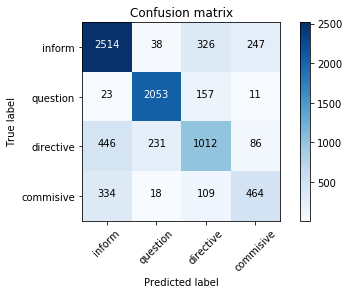

In [45]:
plot_confusion_matrix(cmat, classes)

Normalized confusion matrix
[[0.80448    0.01216    0.10432    0.07904   ]
 [0.01024955 0.91488414 0.06996435 0.00490196]
 [0.25126761 0.13014085 0.57014085 0.0484507 ]
 [0.36108108 0.01945946 0.11783784 0.50162162]]


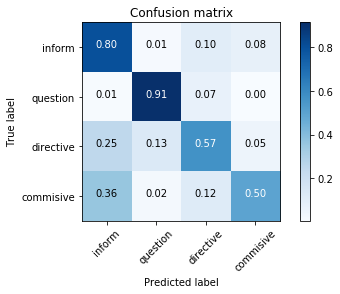

In [46]:
plot_confusion_matrix(cmat, classes, normalize=True)

In [47]:
correctPerClass = {}
totalPerClass   = {}
for cls in [0, 1, 2, 3]:
    correctPerClass[cls] = 0
    totalPerClass[cls]   = 0
for yt, yp in zip(valY_all, preds):
    totalPerClass[yt] += 1
    correctPerClass[yt] += int(yt==yp)



In [48]:
totalPerClass

{0: 3125, 1: 2244, 2: 1775, 3: 925}

In [49]:
correctPerClass

{0: 2514, 1: 2053, 2: 1012, 3: 464}

In [50]:
for cls in [0, 1, 2, 3]:
    acc = float(correctPerClass[cls])/totalPerClass[cls]
    print("Accuracy for class ", cls, " :", acc)

Accuracy for class  0  : 0.80448
Accuracy for class  1  : 0.9148841354723708
Accuracy for class  2  : 0.5701408450704225
Accuracy for class  3  : 0.5016216216216216


# Saving the transition params